In [1]:
#@title Colab setup and imports
#@markdown ## ⚠️ PLEASE NOTE:
#@markdown This colab runs best using a TPU runtime.  From the Colab menu, choose Runtime > Change Runtime Type, then select **'TPU'** in the dropdown.

from datetime import datetime
import functools
import os

from IPython.display import HTML, clear_output
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

if 'COLAB_TPU_ADDR' in os.environ:
    try:
      import brax
    except ImportError:
      !pip install git+https://github.com/flobotics/brax.git@custom_envs
      clear_output()
      import brax
else:
    import brax

from brax import envs
from brax.training import ppo, sac
from brax.io import html
from brax.experimental.composer import composer

if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

2021-09-05 15:45:39.938891: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/galactic/opt/yaml_cpp_vendor/lib:/opt/ros/galactic/opt/rviz_ogre_vendor/lib:/opt/ros/galactic/lib/x86_64-linux-gnu:/opt/ros/galactic/lib


In [4]:
env_name = "ant_cheetah"
env_fn = composer.create_fn(env_name=env_name)
env = env_fn()

/home/ros2/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3027: UserWarning: Explicitly requested dtype float requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")


In [5]:
jit_env_reset = jax.jit(env.reset)
state = jit_env_reset(rng=jax.random.PRNGKey(seed=0))

def visualize(sys, qps):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, qps))

visualize(env.sys, [state.qp])

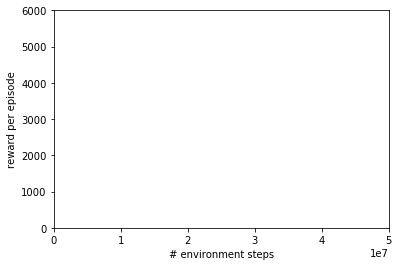

In [ ]:


#@title Training some pre-included Brax environments

# We determined some reasonable hyperparameters offline and share them here.
train_fn = {
  'ant_cheetah': functools.partial(
      ppo.train, num_timesteps = 50000000, log_frequency = 20,
      reward_scaling = 10, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 5, num_minibatches = 32,
      num_update_epochs = 4, discounting = 0.95, learning_rate = 3e-4,
      entropy_cost = 1e-2, num_envs = 2048, batch_size = 1024
  ),
  'humanoid': functools.partial(
      sac.train, num_timesteps = 1048576 * 5,
      log_frequency = 131012, reward_scaling = 30, episode_length = 1000,
      normalize_observations = True, action_repeat = 1, discounting = 0.99,
      learning_rate = 6e-4, num_envs = 64, batch_size = 512,
      min_replay_size = 8192, max_replay_size = 1048576,
      grad_updates_per_step = 0.125, max_devices_per_host=4
  ),
  'fetch': functools.partial(
      ppo.train, num_timesteps = 100_000_000, log_frequency = 20,
      reward_scaling = 5, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 20, num_minibatches = 32,
      num_update_epochs = 4, discounting = 0.997, learning_rate = 3e-4,
      entropy_cost = 0.001, num_envs = 2048, batch_size = 256
  ),
  'grasp': functools.partial(
      ppo.train, num_timesteps = 600_000_000, log_frequency = 10,
      reward_scaling = 10, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 20, num_minibatches = 32,
      num_update_epochs = 2, discounting = 0.99, learning_rate = 3e-4,
      entropy_cost = 0.001, num_envs = 2048, batch_size = 256
  ),
  'halfcheetah': functools.partial(
      ppo.train, num_timesteps = 100_000_000, log_frequency = 10,
      reward_scaling = 1, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 20, num_minibatches = 32,
      num_update_epochs = 8, discounting = 0.95, learning_rate = 3e-4,
      entropy_cost = 0.001, num_envs = 2048, batch_size = 512
  ),
  'ur5e': functools.partial(
      ppo.train, num_timesteps = 20_000_000, log_frequency = 20,
      reward_scaling = 10, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 5, num_minibatches = 32,
      num_update_epochs = 4, discounting = 0.95, learning_rate = 2e-4,
      entropy_cost = 1e-2, num_envs = 2048, batch_size = 1024,
      max_devices_per_host = 8
  ),
  'reacher': functools.partial(
      ppo.train, num_timesteps = 100_000_000, log_frequency = 20,
      reward_scaling = 5, episode_length = 1000, normalize_observations = True,
      action_repeat = 4, unroll_length = 50, num_minibatches = 32,
      num_update_epochs = 8, discounting = 0.95, learning_rate = 3e-4,
      entropy_cost = 1e-3, num_envs = 2048, batch_size = 256,
      max_devices_per_host = 8, seed = 1),
  'testenv': functools.partial(
      ppo.train, num_timesteps = 100_000_000, log_frequency = 20,
      reward_scaling = 5, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 20, num_minibatches = 32,
      num_update_epochs = 4, discounting = 0.997, learning_rate = 3e-4,
      entropy_cost = 0.001, num_envs = 2048, batch_size = 256
  ),
  'testenv2': functools.partial(
      ppo.train, num_timesteps = 100_000_000, log_frequency = 20,
      reward_scaling = 5, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 20, num_minibatches = 32,
      num_update_epochs = 4, discounting = 0.997, learning_rate = 3e-4,
      entropy_cost = 0.001, num_envs = 2048, batch_size = 256
  ),
}[env_name]
max_y = {'ant_cheetah': 6000, 
         'humanoid': 12000, 
         'fetch': 15, 
         'grasp': 100, 
         'halfcheetah': 8000,
         'ur5e': 10,
         'reacher': 5,
         'testenv': 15000,
         'testenv2': 15000}[env_name]

min_y = {'reacher': -100}.get(env_name, 0)
min_y = {'testenv': -10000}.get(env_name, 0)
min_y = {'testenv2': -10000}.get(env_name, 0)

xdata = []
ydata = []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

inference_fn, params, _ = train_fn(environment_fn=env_fn, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [ ]:
#@title Visualizing a trajectory of the learned inference function

jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)
rng = jax.random.PRNGKey(seed=0)
reset_key, rng = jax.random.split(rng)
state = jit_env_reset(rng=reset_key)
qps = []
while not state.done:
  qps.append(state.qp)
  tmp_key, rng = jax.random.split(rng)
  act = jit_inference_fn(params, state.obs, tmp_key)
  state = jit_env_step(state, act)

visualize(env.sys, qps)